# 1. Kaggle Digit Recongnizer

Using Pytorch identifies MNISTdataset.  
Dataset from kaggle

## Import Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

## Import Data

In [2]:
print(os.listdir(r"E:\data\digit_recognizer"))

['sample_submission.csv', 'test.csv', 'train.csv']


In [3]:
train = pd.read_csv(r"E:/data/digit_recognizer/train.csv", dtype=np.float32)
test = pd.read_csv(r"E:/data/digit_recognizer/test.csv", dtype=np.float32)
sample_sub = pd.read_csv(r"E:/data/digit_recognizer/sample_submission.csv")
train.label.head()

0    1.0
1    0.0
2    1.0
3    4.0
4    0.0
Name: label, dtype: float32

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: float32(785)
memory usage: 125.8 MB


## Preparing Dataset

Because of type of dataset from .csv, we should transform to prepared Tensor(image).
- we get raw data and want to split train dataset and test date. Before split images dataset, we should Normalization dataset(0-255 -> 0-1).
- splited dataset transform to Tensor and loader Tensor.

*Because we using Normalization, we do not using transforms to enhance data*

In [5]:
target_np = train.label.values
features_np = train.loc[:, train.columns != 'label'].values/255

features_train, features_test, target_train, target_test = train_test_split(
    features_np, target_np, test_size=0.2, random_state=42)

In [6]:
featuresTrain = torch.from_numpy(features_train)
targetTrain = torch.from_numpy(target_train).type(torch.LongTensor)

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(target_test).type(torch.LongTensor)

In [7]:
batch_size = 32

train = TensorDataset(featuresTrain, targetTrain)
test = TensorDataset(featuresTest, targetsTest)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

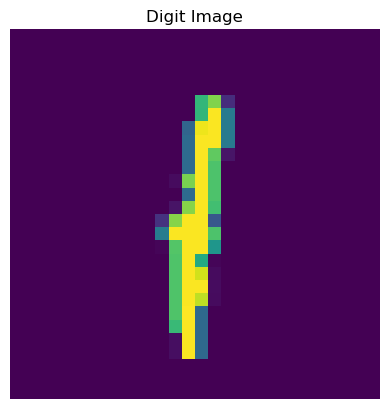

In [8]:
# show data
def visualize_image(data, index, pred=False, val=0):
    plt.imshow(data[index].reshape(28, 28))
    plt.axis('off')
    plt.title("Digit Image")
    plt.show()


visualize_image(features_np, 12)

## Define Network Architecture

- Pytorch provides some classic architecture, but MNISTdata is too simple we select to build a simple neural networks *Since building a neural networks by self, we do not build a network the layer over 6*.
- Because it is a 10 classes, we final layer using softmax.

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)
        self.log_softmax = F.log_softmax

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        out = self.log_softmax(self.fc5(x), dim=1)
        return out

## Train and Validation

- Define some keys(criterion and optimizer) and some arguments
- Some basic steps for training model
  - make a forward pass through the network
  - calculate the loss
  - backward pass get gradients (loss.backward)
  - step the optimizer and update weights

In [10]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)

epochs = 5
steps = 0
print_every = 50
train_losses, test_losses = [], []

In [11]:
for epoch in range(epochs):
    running_loss = 0
    for img, labels in train_loader:
        steps += 1
        optimizer.zero_grad()
        yhat = model(img)
        loss = criterion(yhat, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            with torch.no_grad():
                model.eval()
                for img, labels in test_loader:
                    yhat = model(img)
                    test_loss += criterion(yhat, labels)
                    temp_yhat = torch.exp(yhat)
                    top_p, top_class = temp_yhat.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(epoch+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                  "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/5..  Training Loss: 0.077..  Test Loss: 0.786..  Test Accuracy: 0.730
Epoch: 1/5..  Training Loss: 0.112..  Test Loss: 0.549..  Test Accuracy: 0.834
Epoch: 1/5..  Training Loss: 0.139..  Test Loss: 0.440..  Test Accuracy: 0.866
Epoch: 1/5..  Training Loss: 0.161..  Test Loss: 0.372..  Test Accuracy: 0.893
Epoch: 1/5..  Training Loss: 0.182..  Test Loss: 0.379..  Test Accuracy: 0.888
Epoch: 1/5..  Training Loss: 0.201..  Test Loss: 0.327..  Test Accuracy: 0.905
Epoch: 1/5..  Training Loss: 0.217..  Test Loss: 0.296..  Test Accuracy: 0.914
Epoch: 1/5..  Training Loss: 0.236..  Test Loss: 0.289..  Test Accuracy: 0.916
Epoch: 1/5..  Training Loss: 0.251..  Test Loss: 0.255..  Test Accuracy: 0.924
Epoch: 1/5..  Training Loss: 0.267..  Test Loss: 0.267..  Test Accuracy: 0.926
Epoch: 1/5..  Training Loss: 0.282..  Test Loss: 0.241..  Test Accuracy: 0.934
Epoch: 1/5..  Training Loss: 0.293..  Test Loss: 0.286..  Test Accuracy: 0.917
Epoch: 1/5..  Training Loss: 0.306..  Test Loss: 0.2

Epoch: 5/5..  Training Loss: 0.102..  Test Loss: 0.116..  Test Accuracy: 0.972


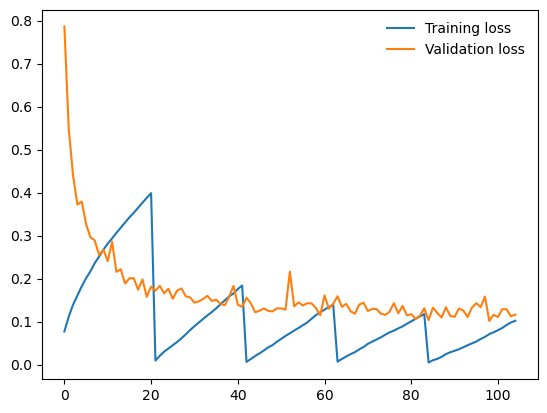

In [12]:
%matplotlib inline
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [13]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

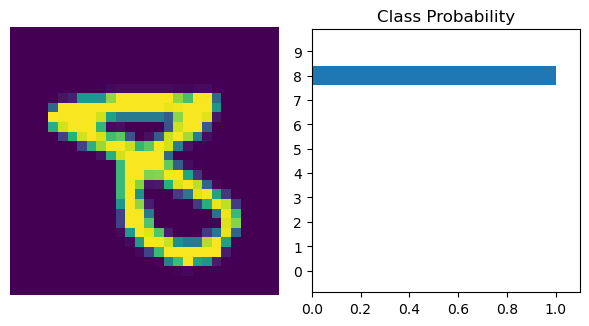

In [15]:
%matplotlib inline
def make_prediction(data):
    images, labels = next(iter(data))

    img = images[24].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    view_classify(img.view(1, 28, 28), ps)
make_prediction(test_loader)